In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import levenberg_marquardt
from matplotlib.pyplot import figure
import heston
from importlib import reload
reload(heston)
from heston import calibrate_heston
import datetime
import matplotlib.dates as mdates
from tqdm.notebook import tqdm

In [5]:
df = pd.read_csv(f"../datasets/deribit_options_chain_2022-12-01_OPTIONS.csv")
df = df.drop(columns = ["exchange", "open_interest", 
                    "last_price", "bid_price", "bid_amount", "bid_iv",
                           "ask_price", "ask_amount", "ask_iv", "underlying_index",
                           "delta", "gamma", "vega", "theta" ,"rho"])
currency = "ETH"
ind = [symbol.startswith(currency) for symbol in df.symbol]
df = df[ind].reset_index(drop=True)

In [6]:
df.head()

,symbol,timestamp,local_timestamp,type,strike_price,expiration,mark_price,mark_iv,underlying_price
0,ETH-9DEC22-1400-C,1669852800002000,1669852800011631,call,1400,1670572800000000,0.0146,69.75,1294.5900
1,ETH-16DEC22-1300-P,1669852800011000,1669852800014218,put,1300,1671177600000000,0.0632,74.51,1294.5233
2,ETH-16DEC22-1500-C,1669852800010000,1669852800017777,call,1500,1671177600000000,0.0140,73.44,1294.5233
3,ETH-30DEC22-1400-P,1669852800013000,1669852800018794,put,1400,1672387200000000,0.1325,72.78,1294.2700
4,ETH-2DEC22-1300-C,1669852800013000,1669852800019006,call,1300,1669968000000000,0.0147,69.18,1294.4500


In [17]:
# calibrate base
number_of_dots = 20
kappas, nu_bars, sigmas, rhos, nu0s, errors = [], [], [], [], [], []
a = np.float64(3.0)  # kappa                     |  mean reversion rate
b = np.float64(0.1)  # v_infinity               |  long term variance
c = np.float64(0.25)  # sigma                    |  volatility of volatility
rho = np.float64(0.01)  # rho                    |  correlation between spot and volatility
v0 = np.float64(0.08) # init variance            | initial variance   
start_params = np.array([a, b, c, rho, v0])
print("Optimize first params with random start once")
calibrated_params, first_error = calibrate_heston(df = df, start_params = start_params)

# Get ticks with similar distnce from available data
timestamps = np.linspace(df.timestamp.min(), df.timestamp.max(), number_of_dots)
for timestamp in tqdm(timestamps):
    calibrated_params, error = calibrate_heston(df = df, start_params = calibrated_params, timestamp = timestamp)
    kappas.append(calibrated_params[0])
    nu_bars.append(calibrated_params[1])
    sigmas.append(calibrated_params[2])
    rhos.append(calibrated_params[3])
    nu0s.append(calibrated_params[4])
    errors.append(error)
    
timestamps_hm = [datetime.datetime.fromtimestamp(x/1000000.0) for x in timestamps]

Optimize first params with random start once
Optimized parameters:
('kappa', 0.44983)
('nu_bar', 3.27158)
('sigma', 3.47724)
('rho', -0.39303)
('nu0', 0.64943)


  0%|          | 0/20 [00:00<?, ?it/s]

Optimized parameters:
('kappa', 3.63836)
('nu_bar', 0.0001)
('sigma', 4.27822)
('rho', -0.51474)
('nu0', 0.62696)
Optimized parameters:
('kappa', 2.33399)
('nu_bar', 1.28854)
('sigma', 4.46852)
('rho', -0.36775)
('nu0', 0.66224)
Optimized parameters:
('kappa', 2.30363)
('nu_bar', 1.28636)
('sigma', 4.39798)
('rho', -0.36428)
('nu0', 0.65705)
Optimized parameters:
('kappa', 2.3093)
('nu_bar', 1.29971)
('sigma', 4.45611)
('rho', -0.36785)
('nu0', 0.65627)
Optimized parameters:
('kappa', 2.30811)
('nu_bar', 1.2918)
('sigma', 4.41223)
('rho', -0.36684)
('nu0', 0.65587)
Optimized parameters:
('kappa', 2.29194)
('nu_bar', 1.29421)
('sigma', 4.39854)
('rho', -0.36574)
('nu0', 0.65669)
Optimized parameters:
('kappa', 2.32198)
('nu_bar', 1.27237)
('sigma', 4.30373)
('rho', -0.35778)
('nu0', 0.64984)
Optimized parameters:
('kappa', 2.52623)
('nu_bar', 1.24396)
('sigma', 4.4765)
('rho', -0.35842)
('nu0', 0.64466)
Optimized parameters:
('kappa', 2.48495)
('nu_bar', 1.25912)
('sigma', 4.48389)
('rh

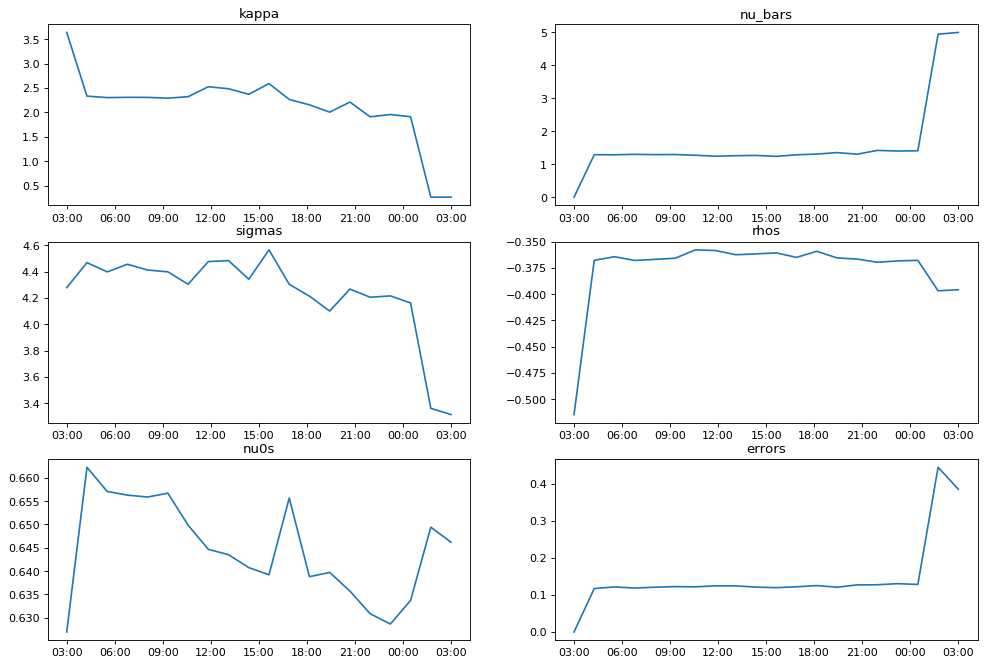

In [18]:
figure(figsize=(15, 10), dpi=80)
ax1 = plt.subplot(321)
ax2 = plt.subplot(322)
ax3 = plt.subplot(323)
ax4 = plt.subplot(324)
ax5 = plt.subplot(325)
ax6 = plt.subplot(326)


ax1.plot(timestamps_hm, kappas)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.set_title("kappa")

ax2.plot(timestamps_hm, nu_bars)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.set_title("nu_bars")

ax3.plot(timestamps_hm, sigmas)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax3.set_title("sigmas")

ax4.plot(timestamps_hm, rhos)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax4.set_title("rhos")


ax5.plot(timestamps_hm, nu0s)
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax5.set_title("nu0s")

ax6.plot(timestamps_hm, errors)
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax6.set_title("errors")

plt.show()